## Relação entre energia elétrica, água encanada e IDHM ##

Agora, iremos analisar dois fatores que em tese estão bem relacionados com o Índice de Desenvolvimento Humano Municipial: o acesso à àgua encanada e energia elétrica. Para isso, vamos comparar dois estados: o Rio de Janeiro, já estudado até agora, e um estado de IDHM menor; o Amazonas, como será mostrado brevemente.


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3 as sql3
import json
import sqlalchemy
import folium
import plotly.express as px
import seaborn as sns

Assim, é necessário repetir os mesmos passos para os dois estados, uma vez que utilizam de dados geográficos diferentes. As colunas que serão relevantes são:
- ano: Ano que o dado foi coletado
- município: Município do estado
- t_agua: Porcentagem da população em domicílios com água encanada
- t_luz: Porcentagem da população em domicílios com energia elétrica
- idhm: Índice de Desenvolvimento Humano Municipal
<!-- spaces -->
Também criaremos a coluna de estado, para que tenhamos a oportunidade de unir os dataframes posteriormente.

In [20]:
#Transporta para variáveis a geografia dos estados e os dados que serão utilizados
mapa_rj = gpd.read_file("RJ.json")
mapa_am = gpd.read_file("AM.json")
db = pd.read_csv("atlas.csv")

# Retira coluna repetida
mapa_rj = mapa_rj.drop(columns="description")
mapa_am = mapa_am.drop(columns="description")

# Filtra apenas as colunas necessárias
db = db[['ano', 'município', 't_agua', 't_luz', 'idhm']]

# Padroniza os nomes
mapa_rj['name'] = mapa_rj['name'].str.title()
mapa_am['name'] = mapa_am['name'].str.title()
db["município"] = db["município"].str.title()
# Filtra os dados para os municípios respectivos dos estados
municipios_rj = mapa_rj["name"].unique()
municipios_am = mapa_am["name"].unique()
db_rj = db[db["município"].isin(municipios_rj)]
db_am = db[db["município"].isin(municipios_am)]
# Cria uma coluna de estado
db_rj['estado'] = "Rio de Janeiro"
db_am['estado'] = "Amazonas"

# Retira dados duplicados
db_rj = db_rj.drop_duplicates(subset=['município', 'ano'])
db_am = db_am.drop_duplicates(subset=['município', 'ano'])

C:\Users\Conda\AppData\Local\Temp/ipykernel_16784/3187913511.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_rj['estado'] = "Rio de Janeiro"
C:\Users\Conda\AppData\Local\Temp/ipykernel_16784/3187913511.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  db_am['estado'] = "Amazonas"


Criadas as tabelas que combinam a geografia dos estados com as informações que serão analisadas, filtramos em menores de acordo com o ano. Dessa forma, isolamos dados coerentes para um período de tempo específico. 
<!-- spaces -->
Fizemos a conversão das tabelas para o tipo de GeoDataFrame e criamos a tabela _RJAM2010_, que contém todos os dados para os dois estados no ano de 2010.

In [3]:
# Junção da geografia com os dados informativos
mergedrj = db_rj.merge(mapa_rj, left_on="município", right_on="name")
mergedam = db_am.merge(mapa_am, left_on="município", right_on="name")
# Filtra pelo ano de 2010
db_rj_2010 = db_rj[db_rj["ano"] == 2010]
db_am_2010 = db_am[db_am["ano"] == 2010]
# Cria dataframes apenas com as colunas de interesse
RJluz = db_rj_2010[['t_luz']]
AMluz = db_am_2010[['t_luz']]
RJagua = db_rj_2010[['t_agua']]
AMagua = db_am_2010[['t_agua']]

# Transforma os dados em GeoData
mergedrj = gpd.GeoDataFrame(mergedrj)
mergedam = gpd.GeoDataFrame(mergedam)
#Faz o mesmo para os dados que contém ano igual a 2010
mergedrj2010 = gpd.GeoDataFrame(db_rj_2010.merge(mapa_rj, left_on="município", right_on="name"))
mergedam2010 = gpd.GeoDataFrame(db_am_2010.merge(mapa_am, left_on="município", right_on="name"))
# Cria um dataframe que junta tanto Rio de Janeiro quanto Amazonas
RJAM2010 = mergedrj2010.append(mergedam2010)

Apenas para confirmar o que foi dito anteriormetne, comparamos o IDHM dos dois estados e comprovamos que há uma diferença considerável em seus valores.

In [4]:
# Média dos estados
print("Média do IDHM do Rio de Janeiro =",mergedrj2010["idhm"].mean(), "\nMédia do IDHM do Amazonas =", mergedam2010["idhm"].mean())

Média do IDHM do Rio de Janeiro = 0.7030652173913043 
Média do IDHM do Amazonas = 0.5651129032258065


Criado a tabela conjunta, podemos criar um mapa interativo. Nele, é possível navegar e verificar os valores isoladamente em cada estado. Para aplicar tanto a variável de energia elétrica quanto água encanada, utilizamos a função de camadas. Assim, elas são representadas respectivamente pelas cores vermelho e azul.

In [19]:
# Criação de um mapa interativo com regiões do Rio de Janeiro e Amazonas destacados
mapRJAM = folium.Map(location=[-10, -55], zoom_start=4)

RJAM2010.explore(m = mapRJAM, 
                    column = 't_luz', # Define a variável de energia elétrica como cor
                    tooltip=["município", "t_agua", "t_luz"], # Valores mostrados com interação do mouse
                    name= 'Energia Elétrica', # Nome da camada
                    legend_kwds = {'caption':'Porcentagem com acesso a luz elétrica'}, # Legenda
                    cmap = "Reds", # Cores utilizadas
                    vmin = 0, # Valor mínimo
                    vmax = 100 # Valor máximo
                    )



RJAM2010.explore(m = mapRJAM,
                    column = 't_agua', # Define a variável de energia elétrica como cor
                    tooltip=["município", "t_agua", "t_luz"], # Valores mostrados com interação do mouse
                    name= 'Água encanada', # Nome da camada
                    legend_kwds = {'caption':'Porcentagem com acesso a água encanada'}, # Legenda
                    cmap = "Blues", # Cores utilizadas
                    vmin = 0, # Valor mínimo
                    vmax = 100 # Valor máximo
                    )
folium.LayerControl().add_to(mapRJAM) # Cria sistema de camadas
mapRJAM

Com esse mapa, podemos perceber dois fatos interessantes: o primeiro é que o Rio de Janeiro possui cores (e consequentemente as porcentagens que elas representam) praticamente homogêneas, enquanto em Amazonas elas são bem variadas.
<!-- spaces -->
O outro fato é que as cores do Rio de Janeiro são bem mais fortes, ou seja, a porcentagem é bem maior do que no Amazonas. Já conseguimos criar uma ideia então de que o IDHM é influenciado por essas duas variáveis.

In [6]:
# Média dos estados
print("Média de energia elétrica do Rio de Janeiro =",mergedrj2010["t_luz"].mean(),"\nMédia de água encanada do Rio de Janeiro =", mergedrj2010["t_agua"].mean(),"\nMédia de energia elétrica do Amazonas =",mergedam2010["t_luz"].mean(),"\nMédia de água encanada do Amazonas =", mergedam2010["t_agua"].mean())

Média de energia elétrica do Rio de Janeiro = 99.52032608695649 
Média de água encanada do Rio de Janeiro = 91.7083695652174 
Média de energia elétrica do Amazonas = 82.92322580645163 
Média de água encanada do Amazonas = 58.23629032258064


Calculando a média dessas porcentagens, confirmamos que as porcentagens do Rio realmente são maiores. Porém, para medir o quanto são variáveis, podemos olhar também seus quartis.

In [7]:
# Quantis dos estados
print("Quantis de energia elétrica do Rio de Janeiro: \n",mergedrj2010["t_luz"].quantile([0.25,0.5,0.75]), "\nQuantis de água encanada do Rio de Janeiro:\n",mergedrj2010["t_agua"].quantile([0.25,0.5,0.75]),"\nQuantis de energia elétrica do Amazonas: \n",mergedam2010["t_luz"].quantile([0.25,0.5,0.75]), "\nQuantis de água encanada do Amazonas:\n",mergedam2010["t_agua"].quantile([0.25,0.5,0.75]))

Quantis de energia elétrica do Rio de Janeiro: 
 0.25    99.6375
0.50    99.8900
0.75    99.9700
Name: t_luz, dtype: float64 
Quantis de água encanada do Rio de Janeiro:
 0.25    89.2550
0.50    93.4250
0.75    96.5125
Name: t_agua, dtype: float64 
Quantis de energia elétrica do Amazonas: 
 0.25    77.8600
0.50    83.5600
0.75    90.0725
Name: t_luz, dtype: float64 
Quantis de água encanada do Amazonas:
 0.25    48.3975
0.50    56.7550
0.75    67.5850
Name: t_agua, dtype: float64


E também obtemos a confirmação do que foi observado no mapa. Contudo, para deixar ainda mais fácil de visualizar, podemos montar um boxplot:

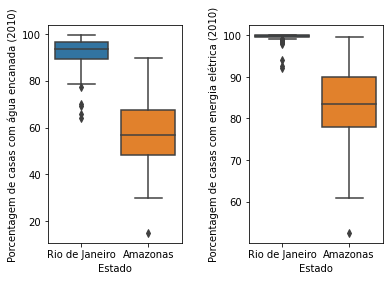

In [8]:
# Criação do boxplot
# Define que a figura terá duas colunas
fig, axs = plt.subplots(ncols=2)

# Define a primeira coluna como boxplot de água encanada
sns.boxplot(x = 'estado', y= 't_agua', data=RJAM2010, ax=axs[0]).set(xlabel="Estado", ylabel="Porcentagem de casas com água encanada (2010)")
# Define a segunda coluna como boxplot de energia elétrica
sns.boxplot(x = 'estado', y= 't_luz', data=RJAM2010, ax=axs[1]).set(xlabel="Estado", ylabel="Porcentagem de casas com energia elétrica (2010)")
# Altera a distância entre as duas colunas
fig.subplots_adjust(wspace=0.5)
# Mostra a figura
plt.show()

Vemos assim que a variação entre valores do Rio de Janeiro são tão pequenas, que no quesito de energia elétrica seu boxplot quase se apresenta como uma única linha. Para finalizar, vamos calcular a correlação entre essas variáveis e o IDHM.

In [9]:
# Correlação com IDHM em 2010
print("Correlação entre Água Encanada e IDHM do Rio de Janeiro em 2010 =", mergedrj2010['t_agua'].corr(mergedrj2010['idhm']), "\nCorrelação entre Energia Elétrica e IDHM do Rio de Janeiro em 2010 =", mergedrj2010['t_luz'].corr(mergedrj2010['idhm']), "\nCorrelação entre Água Encanada e IDHM de Amazonas em 2010 =", mergedam2010['t_agua'].corr(mergedam2010['idhm']), "\nCorrelação entre Energia Elétrica e IDHM de Amazonas em 2010 =", mergedam2010['t_luz'].corr(mergedam2010['idhm']))

Correlação entre Água Encanada e IDHM do Rio de Janeiro em 2010 = 0.2864169330554553 
Correlação entre Energia Elétrica e IDHM do Rio de Janeiro em 2010 = 0.49965014744469466 
Correlação entre Água Encanada e IDHM de Amazonas em 2010 = 0.6030386351331251 
Correlação entre Energia Elétrica e IDHM de Amazonas em 2010 = 0.531809865426426


Porém, esses resultados são curiosos, pois a correlação não é tão forte assim. Portanto, iremos repetir esse cálculo para os dados dos anos 2000 e 1991. Primeiro, vamos criar as tabelas:

In [10]:
# Cria dataframes para o ano de 2000
db_rj_2000 = db_rj[db_rj["ano"] == 2000]
db_am_2000 = db_am[db_am["ano"] == 2000]
mergedrj2000 = gpd.GeoDataFrame(db_rj_2000.merge(mapa_rj, left_on="município", right_on="name"))
mergedam2000 = gpd.GeoDataFrame(db_am_2000.merge(mapa_am, left_on="município", right_on="name"))

# Cria dataframes para o ano de 1991
db_rj_1991 = db_rj[db_rj["ano"] == 1991]
db_am_1991 = db_am[db_am["ano"] == 1991]
mergedrj1991 = gpd.GeoDataFrame(db_rj_1991.merge(mapa_rj, left_on="município", right_on="name"))
mergedam1991 = gpd.GeoDataFrame(db_am_1991.merge(mapa_am, left_on="município", right_on="name"))

Repetindo o processo para o ano 2000, temos:

In [11]:
# Correlação com IDHM em 2000
print("Correlação entre Água Encanada e IDHM do Rio de Janeiro =", mergedrj2000['t_agua'].corr(mergedrj2000['idhm']), "\nCorrelação entre Energia Elétrica e IDHM do Rio de Janeiro =", mergedrj2000['t_luz'].corr(mergedrj2000['idhm']), "\nCorrelação entre Água Encanada e IDHM de Amazonas =", mergedam2000['t_agua'].corr(mergedam2000['idhm']), "\nCorrelação entre Energia Elétrica e IDHM de Amazonas =", mergedam2000['t_luz'].corr(mergedam2000['idhm']))

Correlação entre Água Encanada e IDHM do Rio de Janeiro = 0.636388932511271 
Correlação entre Energia Elétrica e IDHM do Rio de Janeiro = 0.6374362216963367 
Correlação entre Água Encanada e IDHM de Amazonas = 0.7050510241367854 
Correlação entre Energia Elétrica e IDHM de Amazonas = 0.4866517869076961


Vemos que os valores de correlação aumentaram. Vamos repetir também para o ano de 1991:

In [12]:
# Correlação com IDHM em 1991
print("Correlação entre Água Encanada e IDHM do Rio de Janeiro =", mergedrj1991['t_agua'].corr(mergedrj1991['idhm']), "\nCorrelação entre Energia Elétrica e IDHM do Rio de Janeiro =", mergedrj1991['t_luz'].corr(mergedrj1991['idhm']), "\nCorrelação entre Água Encanada e IDHM de Amazonas =", mergedam1991['t_agua'].corr(mergedam1991['idhm']), "\nCorrelação entre Energia Elétrica e IDHM de Amazonas =", mergedam1991['t_luz'].corr(mergedam1991['idhm']))

Correlação entre Água Encanada e IDHM do Rio de Janeiro = 0.8210638478618384 
Correlação entre Energia Elétrica e IDHM do Rio de Janeiro = 0.7534794478325422 
Correlação entre Água Encanada e IDHM de Amazonas = 0.588249082030594 
Correlação entre Energia Elétrica e IDHM de Amazonas = 0.6829146480450268


E novamente, os valores aumentaram; agora, a correlação é forte. Revendo os resultados para 2010, vemos que as menores correlações estão no estado do Rio de Janeiro. 
<!-- spaces -->
Podemos concluir então que água encanada e energia elétrica nos domicílios realmente são relevantes para o resultado do IDHM. Contudo, uma vez que seus valores são tão constantes quantos o Rio de Janeiro em 2010, temos outros fatores que apontam uma variação maior de IDHM.